# CTD data - one file per cast

Let's first load in some libraries that we are going to use today. If you are not sure whether you have the library installed, you can embed *install.packages* within an *if* statement, like this

In [1]:
if (!requireNamespace("RNetCDF", quietly = TRUE)) {
  install.packages("RNetCDF")
}
library(RNetCDF)
if (!requireNamespace("writexl", quietly = TRUE)) {
  install.packages("writexl")
}
library(writexl)

## One file

The data are available via a THREDDS server that you can find here:
https://opendap1.nodc.no/opendap/physics/point/cruise/nansen_legacy-single_profile/

If you open the link above, you can navigate to different NetCDF files, and you will be linked to OPeNDAP data access forms like this one:
https://opendap1.nodc.no/opendap/physics/point/cruise/nansen_legacy-single_profile/NMDC_Nansen-Legacy_PR_CT_58US_2021704/CTD_station_P1_NLEG01-1_-_Nansen_Legacy_Cruise_-_2021_Seasonal_Study_Q2.nc.html

OPeNDAP makes it possible to access data over the internet without you having to download the data to your computer first. You can just remove the *html* suffix from the URL above and include it in your R script in the same way that you might include some absolute filepath to a file on your computer. 

So now let's load the data into R for this cast.

In [2]:
url <- 'https://opendap1.nodc.no/opendap/physics/point/cruise/nansen_legacy-single_profile/NMDC_Nansen-Legacy_PR_CT_58US_2021704/CTD_station_P1_NLEG01-1_-_Nansen_Legacy_Cruise_-_2021_Seasonal_Study_Q2.nc'
data <- open.nc(url)
print.nc(data)

netcdf classic {
dimensions:
	PRES = 88 ;
variables:
	NC_FLOAT PRES(PRES) ;
		NC_FLOAT PRES:_FillValue = NaN ;
		NC_CHAR PRES:axis = "Z" ;
		NC_CHAR PRES:uncertainty = " " ;
		NC_CHAR PRES:comment = " " ;
		NC_CHAR PRES:ancillary_variables = "PRES_QC" ;
		NC_CHAR PRES:standard_name = "sea_water_pressure" ;
		NC_CHAR PRES:long_name = "Sea pressure" ;
		NC_CHAR PRES:units = "dbar" ;
		NC_CHAR PRES:positive = "down" ;
		NC_CHAR PRES:data_mode = "D" ;
		NC_CHAR PRES:coverage_content_type = "physicalMeasurement" ;
	NC_SHORT PRES_QC(PRES) ;
		NC_SHORT PRES_QC:_FillValue = -127 ;
		NC_CHAR PRES_QC:conventions = "Copernicus Marine In Situ reference table 2" ;
		NC_SHORT PRES_QC:valid_min = 0 ;
		NC_SHORT PRES_QC:valid_max = 9 ;
		NC_SHORT PRES_QC:flag_values = 0, 1, 2, 3, 4, 5, 6, 7, 8, 9 ;
		NC_CHAR PRES_QC:flag_meanings = "no_qc_performed good_data probably_good_data bad_data_that_are_potentially_correctable bad_data value_changed value_below_detection nominal_value interpolated_value missin

The data have a single dimension, pressure. For the profile I have chosen above, there are 82 data points for each variable.

Now let's access a few of the variables.

In [3]:
pres <- var.get.nc(data,'PRES')
temp <- var.get.nc(data,'TEMP')
psal <- var.get.nc(data,'PSAL')

Let's make a basic plot.

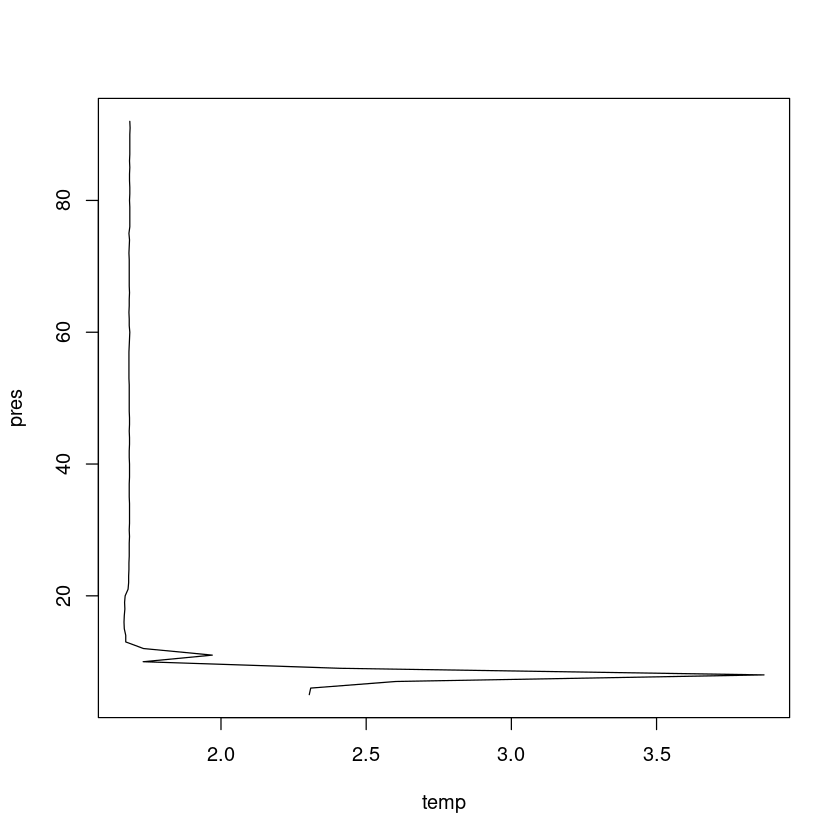

In [4]:
plot(
  temp,
  pres,
  type = "l",
)

Maybe something nicer.

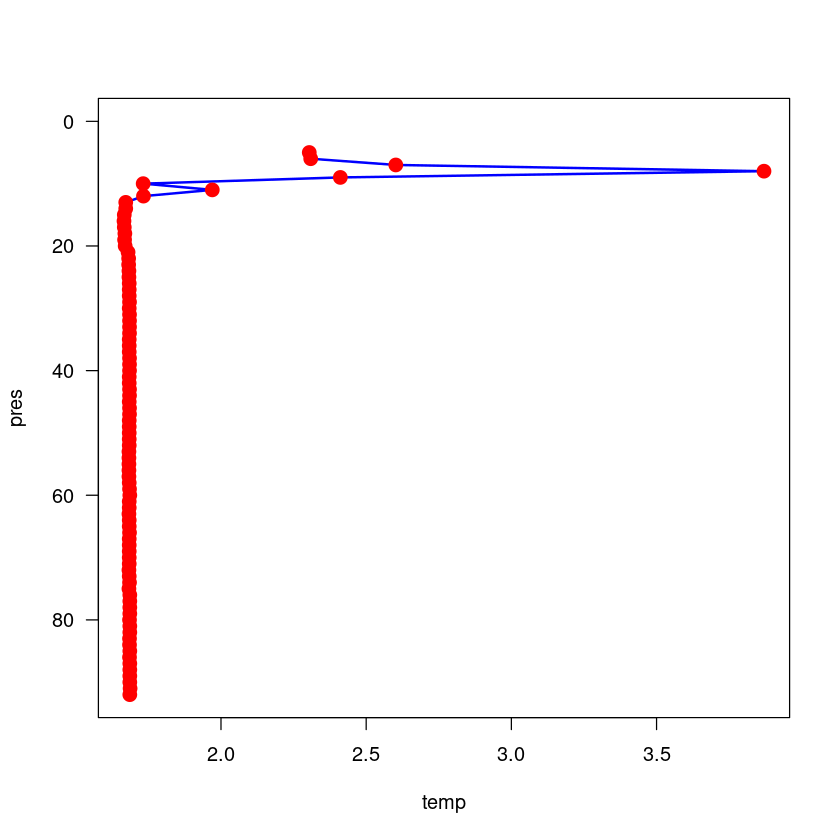

In [5]:
plot(
  temp,
  pres,
  type = "l",
  lwd = 2,     
  col = "blue",
  las = 1,     
  ylim = c(max(pres),0)
)

# Add points on the line plot
points(
  temp, 
  pres, 
  pch = 19, 
  col = "red", 
  cex = 1.5
)

Now let's write the data to a dataframe.

In [6]:
df <- data.frame(Pressure = pres, Temperature = temp, Salinity = psal)

We can write that out to a CSV file or XLSX file if we like.

In [7]:
# Write to CSV
write.csv(df, "../data/ctd_data_one_cast.csv", row.names = FALSE)

# Write to XLSX using writexl
write_xlsx(df, "../data/ctd_data_one_cast.xlsx")

## Looping through multiple files

What if we want to loop through and access all the casts from, for example, a single cruise?

We can think of this as the human interface:
https://opendap1.nodc.no/opendap/physics/point/cruise/nansen_legacy-single_profile/NMDC_Nansen-Legacy_PR_CT_58US_2021704/contents.html

And this as the machine interface:
https://opendap1.nodc.no/opendap/physics/point/cruise/nansen_legacy-single_profile/NMDC_Nansen-Legacy_PR_CT_58US_2021704/catalog.xml

If you have never looked at an XML file like this before, don't worry. What we want to do is access the URL paths of each file and dump them to a list that we can loop through. We need to install another package first.

In [8]:
if (!requireNamespace("xml2", quietly = TRUE)) {
  install.packages("xml2")
}
library(xml2)

Now let's make a list of the OPeNDAP URLs for each file.

In [9]:
# Read the XML file
xml_url <- 'https://opendap1.nodc.no/opendap/physics/point/cruise/nansen_legacy-single_profile/NMDC_Nansen-Legacy_PR_CT_58US_2021704/catalog.xml'
xml_content <- read_xml(xml_url)

# Extract all <thredds:access> nodes with serviceName="dap"
dap_nodes <- xml_find_all(xml_content, ".//thredds:access[@serviceName='dap']", ns = xml_ns(xml_content))

# Extract the URLs
dap_urls <- xml_attr(dap_nodes, "urlPath")

# Base URL
base_url <- "https://opendap1.nodc.no/opendap/"

# Combine base URL with URL paths to get full URLs
full_urls <- paste0(base_url, dap_urls)

# Print the full URLs
print(full_urls)

 [1] "https://opendap1.nodc.no/opendap//physics/point/cruise/nansen_legacy-single_profile/NMDC_Nansen-Legacy_PR_CT_58US_2021704/CTD_station_NLEG-A_-_Nansen_Legacy_Cruise_-_2021_Seasonal_Study_Q2.nc"                
 [2] "https://opendap1.nodc.no/opendap//physics/point/cruise/nansen_legacy-single_profile/NMDC_Nansen-Legacy_PR_CT_58US_2021704/CTD_station_NLEG-B_-_Nansen_Legacy_Cruise_-_2021_Seasonal_Study_Q2.nc"                
 [3] "https://opendap1.nodc.no/opendap//physics/point/cruise/nansen_legacy-single_profile/NMDC_Nansen-Legacy_PR_CT_58US_2021704/CTD_station_NLEG-C_-_Nansen_Legacy_Cruise_-_2021_Seasonal_Study_Q2.nc"                
 [4] "https://opendap1.nodc.no/opendap//physics/point/cruise/nansen_legacy-single_profile/NMDC_Nansen-Legacy_PR_CT_58US_2021704/CTD_station_NLEG-D_-_Nansen_Legacy_Cruise_-_2021_Seasonal_Study_Q2.nc"                
 [5] "https://opendap1.nodc.no/opendap//physics/point/cruise/nansen_legacy-single_profile/NMDC_Nansen-Legacy_PR_CT_58US_2021704/CTD_station_

Now we need to use a for loop to access each file in turn. Here is a quick example of how a for loop works if you are not familiar.

In [10]:
animals <- c('pig', 'dog', 'horse')

for (animal in animals) {
    message <- paste('Hello there,',animal)
    print(message)
}

[1] "Hello there, pig"
[1] "Hello there, dog"
[1] "Hello there, horse"


Now a more relevant example

In [11]:
for (url in full_urls) {
    # Open the file and extract the data
    data <- open.nc(url)
    pres <- var.get.nc(data,'PRES')
    temp <- var.get.nc(data,'TEMP')
    psal <- var.get.nc(data,'PSAL')
    
    filename <- basename(url)  # Extract the filename
    csv_filename <- sub("\\.nc$", ".csv", filename) # Replace .nc extension with .csv
    
    df <- data.frame(Pressure = pres, Temperature = temp, Salinity = psal)
    #write.csv(df, paste0("../data/", csv_filename), row.names = FALSE)    
}

ERROR: Error in var.inq.nc(ncfile, variable): NetCDF: Variable not found


There is a lot more you can do within the for loop. You could plot the data like above. Just include any code you want to be run on every file between the brackets, and make sure the indentation is okay.

Maybe you want to just access a subset of the data. What about selecting based on the filename?

In [12]:
chosen_station <- 'P3' # Selecting files where this is in the filename

for (url in full_urls) {
    
    filename <- basename(url)  # Extract the filename
    
    if (grepl(chosen_station, filename)) {
        csv_filename <- sub("\\.nc$", ".csv", filename) # Replace .nc extension with .csv
        print(csv_filename)
        
        # Open the file and extract the data
        data <- open.nc(url)
        pres <- var.get.nc(data,'PRES')
        temp <- var.get.nc(data,'TEMP')
        psal <- var.get.nc(data,'PSAL')

        df <- data.frame(Pressure = pres, Temperature = temp, Salinity = psal)
        #write.csv(df, paste0("../data/", csv_filename), row.names = FALSE) 
        
    }
       
}

[1] "CTD_station_P3_NLEG07-1_-_Nansen_Legacy_Cruise_-_2021_Seasonal_Study_Q2.csv"
[1] "CTD_station_P3_NLEG07-2_-_Nansen_Legacy_Cruise_-_2021_Seasonal_Study_Q2.csv"


Or select based on the metadata within the NetCDF files

In [13]:
min_latitude <- 82 # Selecting files where the latitude is above 82 degrees

for (url in full_urls) {
    
    filename <- basename(url)  # Extract the filename
    data <- open.nc(url)
    latitude <- att.get.nc(data, "NC_GLOBAL", "geospatial_lat_max")
    
    if (latitude > min_latitude) {
        csv_filename <- sub("\\.nc$", ".csv", filename) # Replace .nc extension with .csv
        print(csv_filename)
        
        # Open the file and extract the data
        pres <- var.get.nc(data,'PRES')
        temp <- var.get.nc(data,'TEMP')
        psal <- var.get.nc(data,'PSAL')

        df <- data.frame(Pressure = pres, Temperature = temp, Salinity = psal)
        #write.csv(df, paste0("../data/", csv_filename), row.names = FALSE) 
        
    }
       
}

[1] "CTD_station_P7_NLEG25_NPAL16_Ice-1_-_Nansen_Legacy_Cruise_-_2021_Seasonal_Study_Q2.csv"
[1] "CTD_station_P7_NLEG25_NPAL16_Ice-2_-_Nansen_Legacy_Cruise_-_2021_Seasonal_Study_Q2.csv"
[1] "CTD_station_P7_NLEG25_NPAL16_Ice-3_-_Nansen_Legacy_Cruise_-_2021_Seasonal_Study_Q2.csv"


## Citing the data

Parent-child relationships have been used in this data publication. Here is the landing page for the data from the cruise used in this tutorial.
https://doi.org/10.21335/NMDC-515075317

Here is the recommended citation that you can include in your work if you use the data from this cruise.
*Martin Ludvigsen (2022) CTD data from Nansen Legacy Cruise - Seasonal cruise Q2 https://doi.org/10.21335/NMDC-515075317*

You can also navigate further to one part per cast. You can cite one of a couple of casts if these are the only data you have used in this collection. For example

*Martin Ludvigsen (2022) CTD data from Nansen Legacy Cruise - Seasonal cruise Q2 Staion: NLEG-D https://doi.org/10.21335/NMDC-515075317-NLEG-D*

## Citing this tutorial

If you find this tutorial series useful for your work, consider citing the repository:

Luke Marsden. (2024, May 24). Accessing Nansen Legacy data in R. Zenodo. https://doi.org/10.5281/zenodo.11277693

[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.11277693.svg)](https://doi.org/10.5281/zenodo.11277693)